# Visualizing potential monthly and annual savings on a TOU plan

This notebooks contains code to read csv files containing a single month of energy usage data or full year of monthly data, eg:
* `jan_2025_usage.csv`
* `monthly_usage_2024.csv`

As an Xcel customer, I like to understand my energy usage and how it impacts my bill. The feature implemented here is one way to visualize how mid and on-peak usage affects my overall bill.
It also condences all the info in the graph to a single digestible number, which is the possible savings I can attain by shifting my mid and on-peak usage to off-peak hours instead.
It provides valuable info to help me, as a customer, make decisions consistent with the business goal of reducing on-peak usage.

### Usage:
* Requires an environment running python
* Place relevant csv files in the same directory as this nontebook
* Execute the first code cell below to display  monthly and annual graph
* If this is the first time running this notebook, the 4 code cells below the first one must be run to load the source code.

### Improvements:
* refoctor to make code more modular and DRY - move into separate modules
* display cost in more friendly units (eg: $0.50 or $5.00) instead of kWh
* Fetch CSV files from an API intead of requiring a manual download
* write tests
* make it dynamic and interactive (toggle between monthly and daily - turn on/off certain elements - tooltips for improve UX and interpretibility)
* Display TOU rates on the graph
* Need to really think through the UX, as this is a fairly nuanced graph, and users will want to be able to easily understand it.
* This would much more likely be done with Highcharts instead of Python.

Note that this is a rapid-fire MVP/POC and is not production ready code

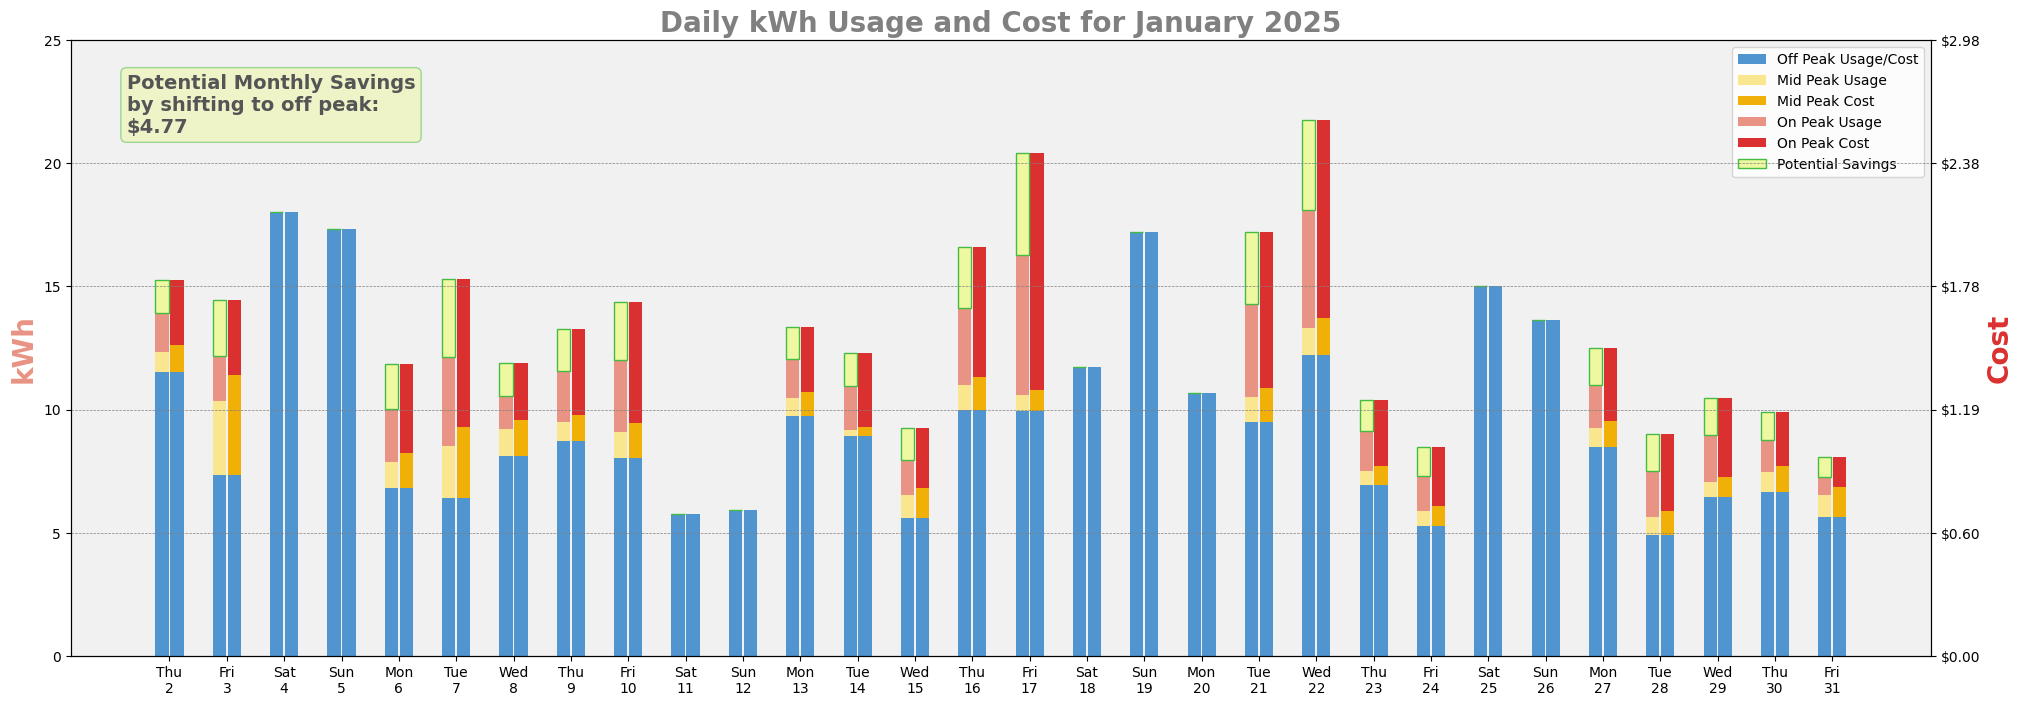

In [307]:
# comment out either line and run this cell to display only one graph
# change show_savings to True/False as desired

plot_daily('/app/xcel_TOU_DEMO/jan_2025_usage.csv', show_savings=True)

# plot_monthly('/app/xcel_TOU_DEMO/monthly_usage_2024.csv', show_savings=True)

In [ ]:
# import necessary libraries and define main functions for daily and monthly usage graphs

import pandas as pd
import matplotlib.pyplot as plt

def plot_daily(csv_file, show_savings=True):
  days = ['Thu', 'Fri', 'Sat', 'Sun', 'Mon', 'Tue', 'Wed']
  plot_title = "Daily kWh Usage and Cost for January 2025"

  main(csv_file, days, plot_title, show_savings)
  
def plot_monthly(csv_file, show_savings=True):
  months=['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
  plot_title = "Monthly kWh Usage and Cost for 2024"
  
  main(csv_file, months, plot_title, show_savings)

def main(csv_file, categories, plot_title, show_savings):
  # read in usage csv file and calculate various metrics
  df = pd.read_csv(csv_file)
  df = calculate_cost(df)
  df = calculate_normalized_to_off_peak_cost(df)
  df = calculate_potential_savings_df(df)
  
  # setup plot
  fig, ax1 = plt.subplots()
  ax2 = ax1.twinx()
  ax1.set_facecolor("#F2F1F1")
  plt.title(plot_title, fontsize=20, color='gray', fontweight='bold')

  plot_kwh_and_cost(df, ax1, show_savings)
  plot_layout(plt, ax1, ax2, df, categories, show_savings)
  


In [ ]:
# variables for cost and color coding

cost_dict = {
  'off_peak': 11.90,
  'mid_peak': 15.98,
  'on_peak': 20.06
}

# colors
c = {
  'off': '#5195D0',
  'mid_u': '#F9E68E', # mid peak usage
  'mid_c': '#F0B008', # mid peak cost
  'on_u': '#E89383',
  'on_c': '#DB3030',
  'sav_f': '#EEF8A0', # fill
  'sav_b': '#44BB44' # border
}


In [297]:
# plot utility functions

def plot_kwh_and_cost(df, ax, show_savings):
  """
  Plot stacked bars, kWh on the left, cost on the right
  """
  w = 0.23 # width
  offset = 0.13
  left = df.category - offset
  right = df.category + offset

  # Off peak bars
  ax.bar(left, df.off_peak, width=w, color=c['off'], label='Off Peak Usage/Cost')
  ax.bar(right, df.off_peak_cost_scaled, width=w, color=c['off'])

  # Mid peak bars
  ax.bar(left, df.mid_peak, width=w, bottom=df.off_peak, color=c['mid_u'], label='Mid Peak Usage')
  ax.bar(right, df.mid_peak_cost_scaled, width=w, bottom=df.off_peak_cost_scaled, color=c['mid_c'], label='Mid Peak Cost')

  # On peak bars
  ax.bar(left, df.on_peak, width=w, bottom=(df.mid_peak + df.off_peak), color=c['on_u'], label='On Peak Usage')
  ax.bar(right, df.on_peak_cost_scaled, width=w, bottom=(df.mid_peak_cost_scaled + df.off_peak_cost_scaled), color=c['on_c'], label='On Peak Cost')

  # potential savings
  if show_savings:
    ax.bar(left, df.total_savings/cost_dict['off_peak'], bottom=(df.off_peak + df.mid_peak + df.on_peak), width=w, edgecolor=c['sav_b'], color=c['sav_f'], label='Potential Savings')

def plot_layout(plt, ax1, ax2, df, categories, show_savings):
  """
  This function sets the layout of the plot, including labels, ticks, and gridlines
  """
  plt.gcf().set_size_inches(24, 8)
  plt.grid(True, which='both', linestyle='--', linewidth=0.5, color='gray', axis='y')
  
  # Show the day of the week and day of month on the x-axis
  plt.xticks(df.category, [f'{categories[i % len(categories)]}\n{df.category.iloc[i] if len(categories) == 7 else ""}' for i in range(len(df.category))])
  
  # Set kWh label on the left y-axis and cost label on the right y-axis
  ax1.set_ylabel('kWh', color=c['on_u'], fontweight='bold', fontsize=20)
  ax2.set_ylabel('Cost', color=c['on_c'], fontweight='bold', fontsize=20)

  # Scale the cost values to match the left y-axis
  ax1.set_ylim(0, ax1.get_yticks()[-1])
  ax2.set_ylim(ax1.get_ylim())
  ax2.set_yticks(ax1.get_yticks())
  ax2.set_yticklabels([f'${(x/100) * cost_dict["off_peak"]:.2f}' for x in ax1.get_yticks()])
 
  if show_savings:
    add_savings_info_box(ax1, df, categories)

  ax1.legend()
  plt.show()

def add_savings_info_box(ax, df, categories):
  """
  Informational box with potential savings - Summarized infor in chart into a single interpretable number.
  """
  interval = "Annual" if len(categories) == 12 else "Monthly"
  savings = df.total_savings.sum() / 100
  savings_message = f'Potential {interval} Savings\nby shifting to off peak:\n${savings:.2f}'
  props = dict(boxstyle='round', facecolor=c['sav_f'], edgecolor=c['sav_b'], alpha=0.5)
  ax.text(0.03, 0.85, savings_message, color='#555555', transform=ax.transAxes, fontsize=14, fontweight='bold', bbox=props)

In [219]:
# DataFrame manipulation functions to add cost and savings columns

def calculate_cost(df):
  """
  Calculate the cost for each usage category and add to the dataframe
  """
  df['on_peak_cost'] = df.on_peak * cost_dict['on_peak']
  df['mid_peak_cost'] = df.mid_peak * cost_dict['mid_peak']
  df['off_peak_cost'] = df.off_peak * cost_dict['off_peak']
  return df

def calculate_normalized_to_off_peak_cost(df):
  """
  Normalize the cost values to the off peak cost so that they display on the same scale as kWh
  add new scaled columns to the dataframe
  """
  df['on_peak_cost_scaled'] =  df.on_peak_cost / cost_dict['off_peak']
  df['mid_peak_cost_scaled'] = df.mid_peak_cost / cost_dict['off_peak']
  df['off_peak_cost_scaled'] = df.off_peak_cost / cost_dict['off_peak']
  return df

def calculate_potential_savings_df(df):
  """
  Calculate the potential savings for each usage category and add to the dataframe
  This is done by calculating the difference between the cost of each category and
  what the cost would be if the energy were used during off peak hours
  """
  df['on_peak_savings'] = (df.on_peak * cost_dict['on_peak']) - (df.on_peak * cost_dict['off_peak'])
  df['mid_peak_savings'] = (df.mid_peak * cost_dict['mid_peak']) - (df.mid_peak * cost_dict['off_peak'])
  df['total_savings'] = df.on_peak_savings + df.mid_peak_savings
  return df
